In [1]:
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
import itertools
import os

# how to download the data
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
# print("Path to dataset files:", path)

In [2]:
sampling_freq, audio = wavfile.read("genres/blues/blues.00000.wav")
mfcc_features = mfcc(audio, sampling_freq)
filterbank_features = logfbank(audio, sampling_freq)

In [3]:
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])


MFCC:
Number of windows = 2994
Length of each feature = 13

Filter bank:
Number of windows = 2994
Length of each feature = 26


10
genres/blues/blues.00093.wav 2994
genres/classical/classical.00079.wav 2994
genres/jazz/jazz.00016.wav 2994
genres/country/country.00088.wav 2994
genres/pop/pop.00027.wav 2992
genres/rock/rock.00011.wav 2994
genres/metal/metal.00022.wav 2992
genres/disco/disco.00052.wav 2992
genres/hiphop/hiphop.00022.wav 2994
genres/reggae/reggae.00080.wav 2992


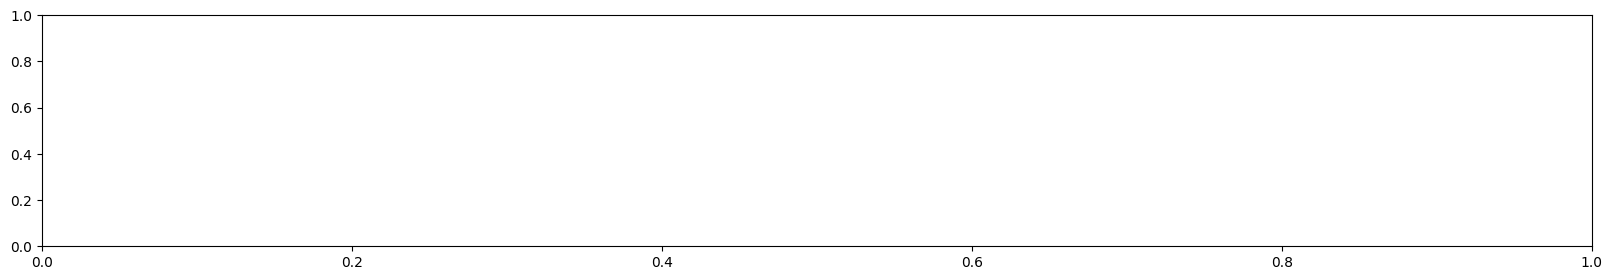

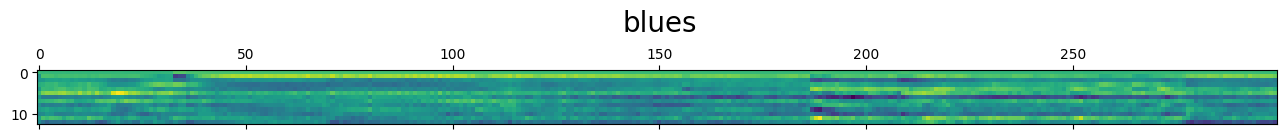

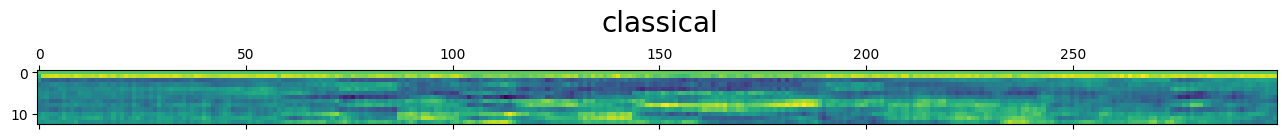

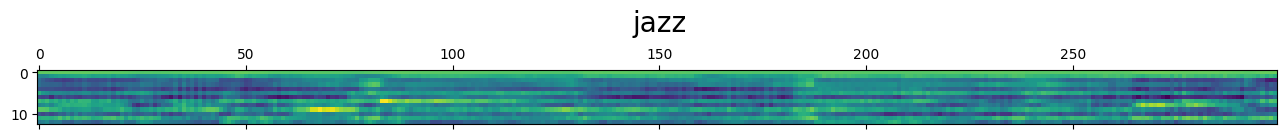

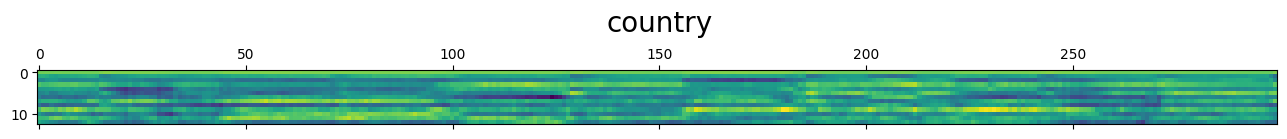

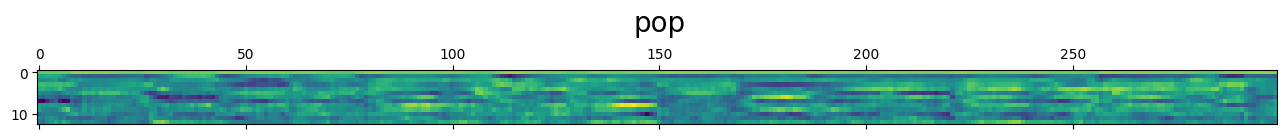

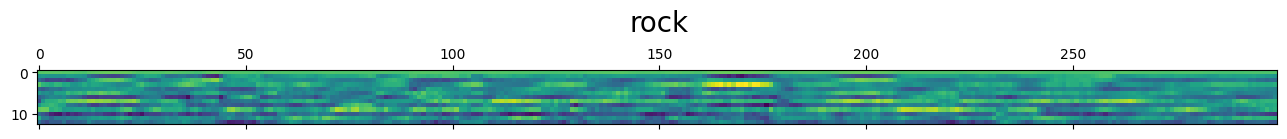

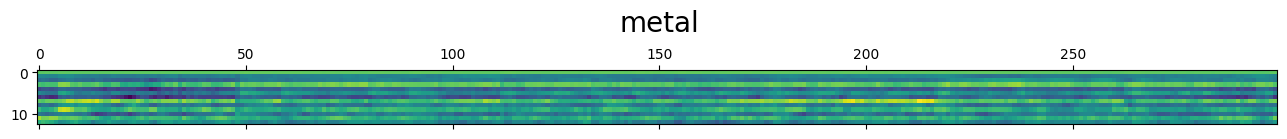

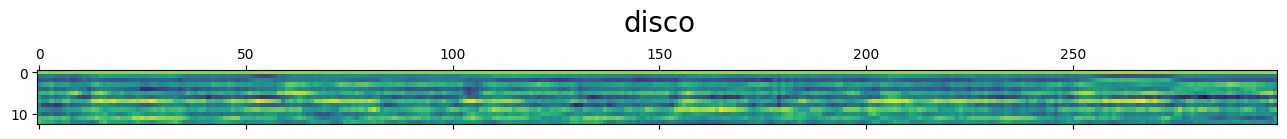

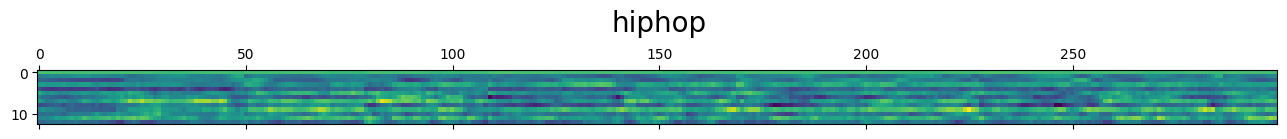

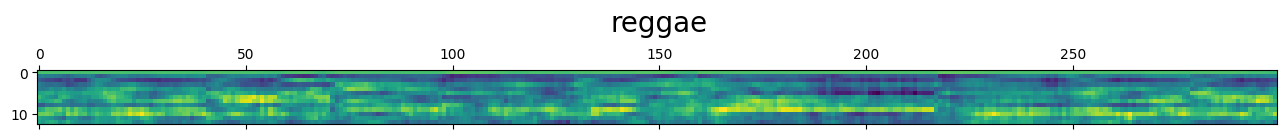

In [4]:
import glob
import os.path as path
genre_list = ["blues","classical", "jazz", "country", "pop", "rock", "metal", "disco", "hiphop", "reggae"]
print(len(genre_list))
figure = plt.figure(figsize=(20,3))
for idx ,genre in enumerate(genre_list): 
   example_data_path = 'genres/' + genre
   file_paths = glob.glob(path.join(example_data_path, '*.wav'))
   sampling_freq, audio = wavfile.read(file_paths[0])
   mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
   #print(mfcc_features)
   print(file_paths[0], mfcc_features.shape[0])
   plt.yscale('linear')
   plt.matshow((mfcc_features.T)[:,:300])
   plt.text(150, -10, genre, horizontalalignment='center', fontsize=20)
 
plt.yscale('linear')
plt.show()

In [5]:
from python_speech_features import mfcc
from scipy.io import wavfile
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define your genres
genre_list = ["blues","classical", "jazz", "country", "pop", "rock", "metal", "disco", "hiphop", "reggae"]
data_dir = 'genres/'
X = []
y = []

# Step 1: extract features
for genre in genre_list:
    genre_path = os.path.join(data_dir, genre)
    file_paths = glob.glob(os.path.join(genre_path, "*.wav"))

    for file_path in file_paths:
        try:
            sampling_freq, audio = wavfile.read(file_path)
            features = mfcc(audio, sampling_freq, nfft=1024)
            
            # Step 2: aggregate features (e.g., mean across time axis)
            mean_features = np.mean(features, axis=0)
            
            X.append(mean_features)
            y.append(genre)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Step 3: train-test split
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Error reading genres/jazz/jazz.00054.wav: File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF', 'RIFX', and 'RF64' supported.


In [6]:
class HMMTrainer(object):
  def __init__(self, model_name='GaussianHMM', n_components=4, cov_type='diag', n_iter=100):
    self.model_name = model_name
    self.n_components = n_components
    self.cov_type = cov_type
    self.n_iter = n_iter
    self.models = []
    if self.model_name == 'GaussianHMM':
      self.model = hmm.GaussianHMM(n_components=self.n_components,        covariance_type=self.cov_type,n_iter=self.n_iter)
    else:
      raise TypeError('Invalid model type') 

  def train(self, X):
    np.seterr(all='ignore')
    self.models.append(self.model.fit(X))
    # Run the model on input data
  def get_score(self, input_data):
    return self.model.score(input_data)

In [7]:
hmm_models = []
input_folder = 'genres/'

# Parse the input directory
for dirname in os.listdir(input_folder):
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder):
        continue

    label = subfolder[subfolder.rfind('/') + 1:]
    X = np.array([])
    y_words = []

    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-20]:
        filepath = os.path.join(subfolder, filename)
        try:
            # Try to read and process the audio file
            sampling_freq, audio = wavfile.read(filepath)
            mfcc_features = mfcc(audio, sampling_freq, nfft=1024)

            # Append features
            if len(X) == 0:
                X = mfcc_features
            else:
                X = np.append(X, mfcc_features, axis=0)

            y_words.append(label)

        except ValueError as e:
            print(f"Skipping file {filepath}: {e}")
        except Exception as e:
            print(f"Unexpected error with file {filepath}: {e}")

    if X.shape[0] > 0:
        print('X.shape =', X.shape)
        hmm_trainer = HMMTrainer(n_components=4)
        hmm_trainer.train(X)
        hmm_models.append((hmm_trainer, label))
        hmm_trainer = None
    else:
        print(f"No valid MFCC data found for label {label}, skipping training.")


X.shape = (239360, 13)
X.shape = (239424, 13)
X.shape = (239580, 13)
X.shape = (239520, 13)
X.shape = (239442, 13)
X.shape = (239655, 13)
X.shape = (239518, 13)
X.shape = (240115, 13)
X.shape = (239619, 13)
Skipping file genres/jazz/jazz.00054.wav: File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF', 'RIFX', and 'RF64' supported.
X.shape = (236717, 13)


In [8]:
input_folder = 'genres/'
real_labels = []
pred_labels = []
for dirname in os.listdir(input_folder):

  subfolder = os.path.join(input_folder, dirname)
  if not os.path.isdir(subfolder):
    continue
  # Extract the label
  label_real = subfolder[subfolder.rfind('/') + 1:]

  for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][-20:]:
    real_labels.append(label_real)
    filepath = os.path.join(subfolder, filename)
    sampling_freq, audio = wavfile.read(filepath)
    mfcc_features = mfcc(audio, sampling_freq, nfft=1024)
    max_score = -9999999999999999999
    output_label = None
    for item in hmm_models:
       hmm_model, label = item
       score = hmm_model.get_score(mfcc_features)
       if score > max_score:
          max_score = score
          output_label = label
    pred_labels.append(output_label)  # ← move this line here


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.7  0.   0.   0.   0.   0.05 0.15 0.   0.05 0.05]
 [0.   0.75 0.   0.   0.   0.2  0.   0.   0.   0.05]
 [0.25 0.   0.5  0.   0.   0.1  0.   0.05 0.   0.1 ]
 [0.15 0.   0.   0.1  0.1  0.   0.3  0.   0.05 0.3 ]
 [0.2  0.   0.05 0.05 0.3  0.   0.25 0.05 0.05 0.05]
 [0.2  0.   0.   0.05 0.   0.65 0.   0.   0.05 0.05]
 [0.   0.   0.2  0.   0.   0.   0.75 0.   0.   0.05]
 [0.   0.   0.1  0.1  0.1  0.   0.   0.6  0.05 0.05]
 [0.   0.   0.   0.   0.3  0.05 0.05 0.3  0.3  0.  ]
 [0.05 0.   0.15 0.2  0.   0.1  0.25 0.   0.05 0.2 ]]


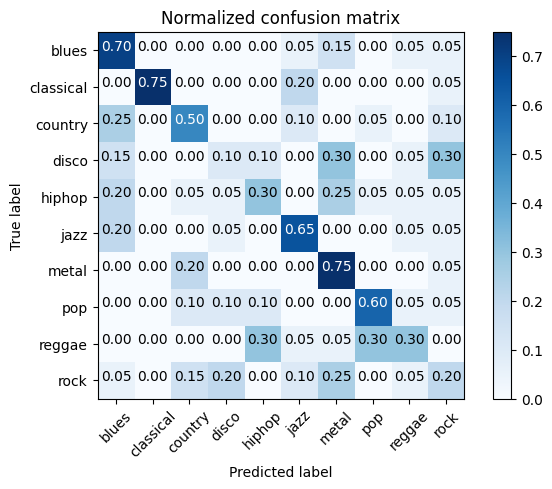

In [10]:
cm = confusion_matrix(real_labels, pred_labels)
np.set_printoptions(precision=2)
classes = ["blues","classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
plt.figure()
plot_confusion_matrix(cm, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

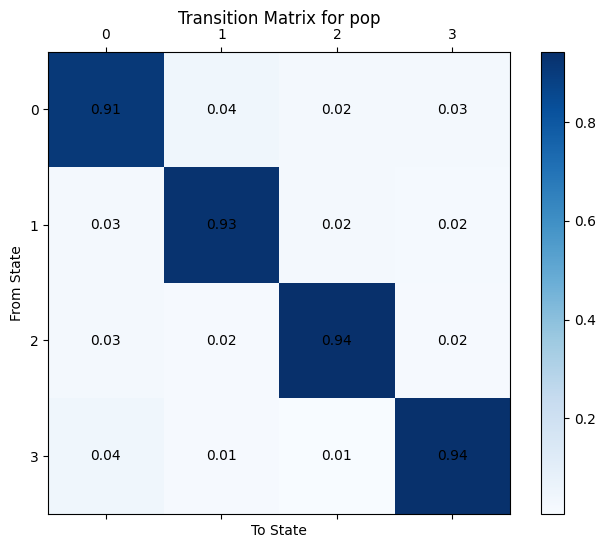

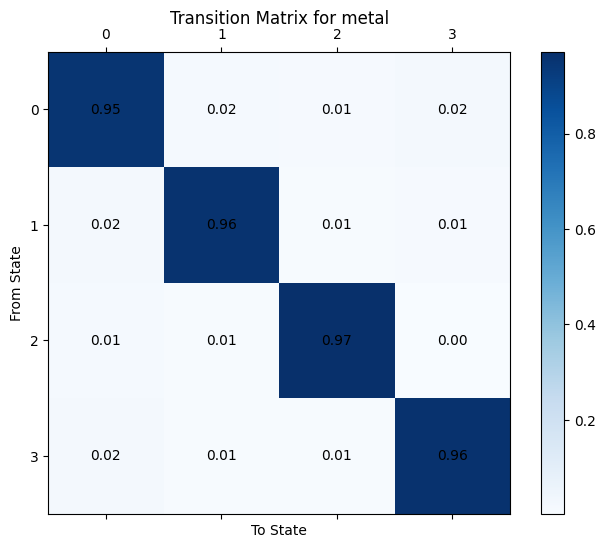

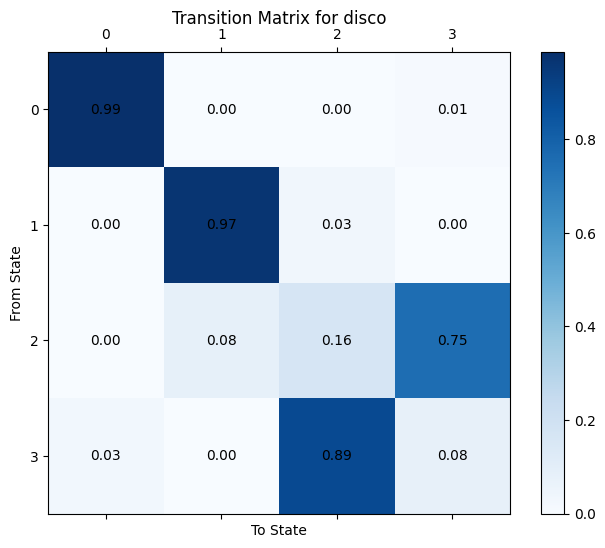

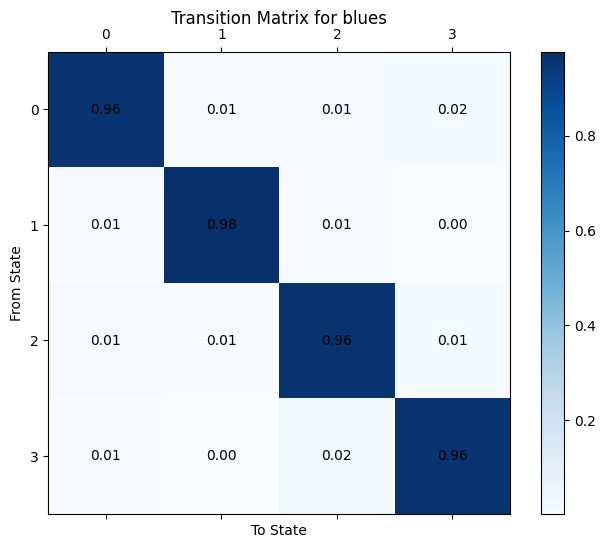

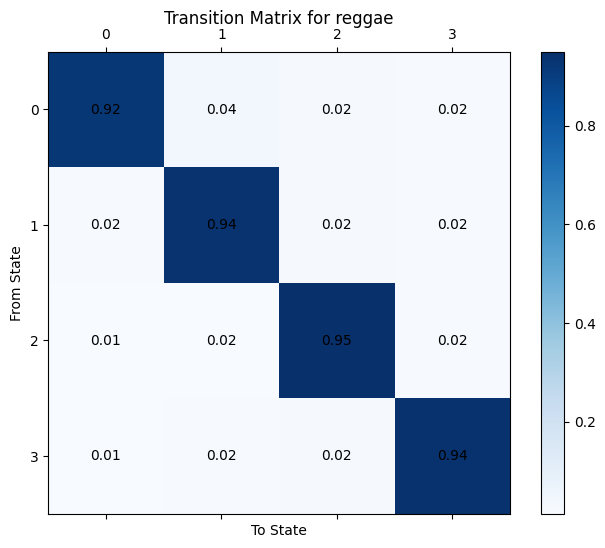

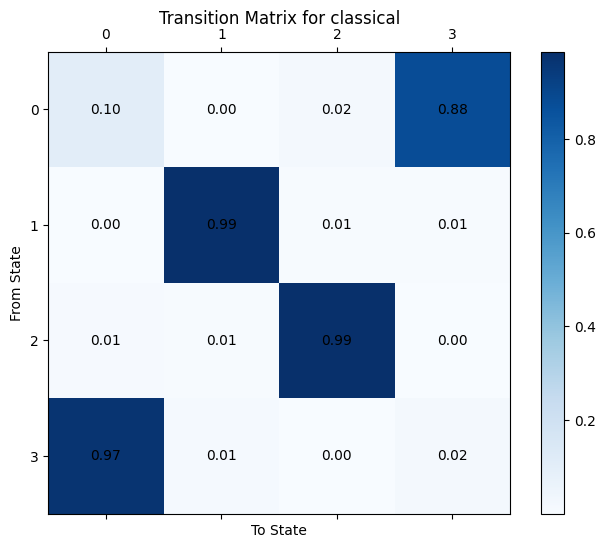

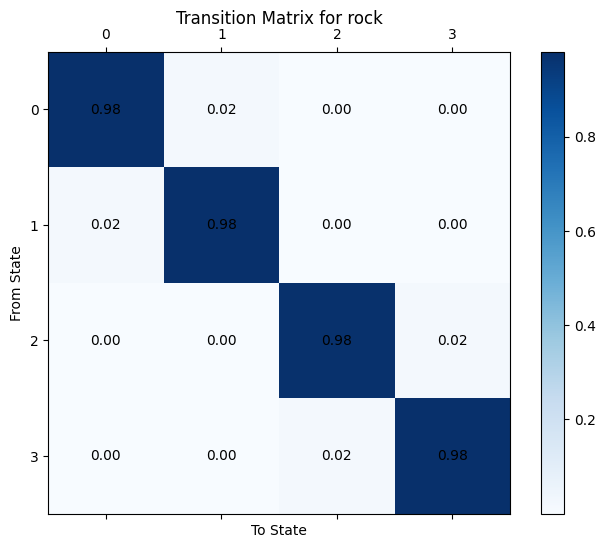

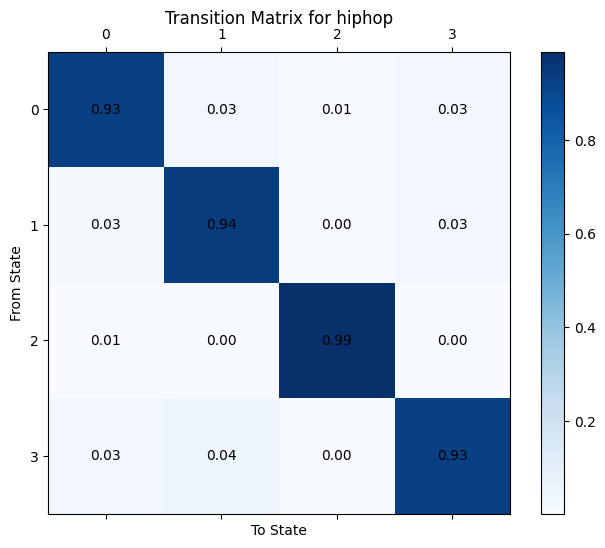

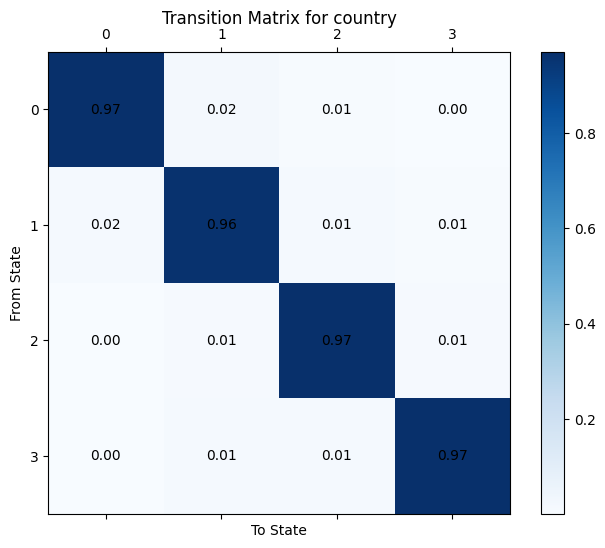

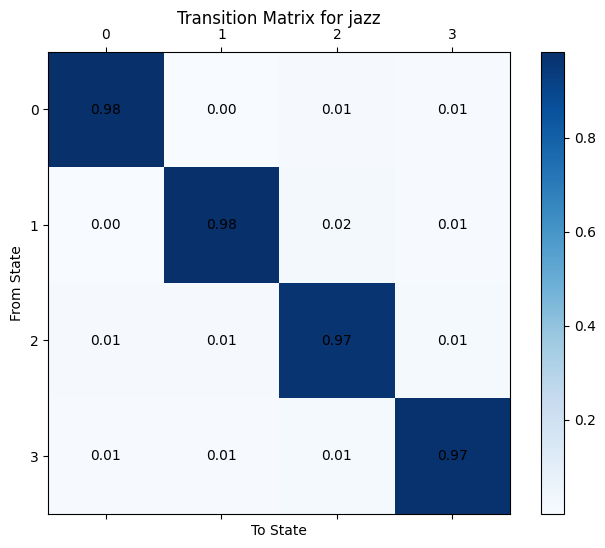

In [14]:
for hmm_model, label in hmm_models:
    matrix = hmm_model.model.transmat_  # access the underlying HMM
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(matrix, cmap='Blues')
    plt.title(f"Transition Matrix for {label}", pad=20)
    fig.colorbar(cax)

    ax.set_xlabel("To State")
    ax.set_ylabel("From State")
    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, f"{matrix[i, j]:.2f}", va='center', ha='center')

    plt.show()

